In [62]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from graphviz import Digraph

In [63]:
def f(x):
    return 3*x**2 - 4*x + 5

In [64]:
f(3.0)

20.0

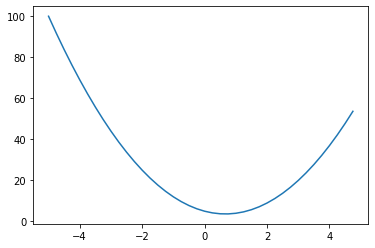

In [65]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [66]:
# Calculate derivative

h = 0.00000001
x = -3.0

(f(x + h) - f(x))/h

-22.00000039920269

In [67]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [68]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2  = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [69]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
       
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    


In [70]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [71]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label='d'
e = d + c; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L'
L

Value(data=-8.0)

In [72]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [73]:
L._op

'*'

In [74]:
# #Visualize expression graph

# def trace(root):
#     nodes, edges = set(), set()
#     def build(v):
#         if v not in nodes:
#             nodes.add(v)
#             for child in v._prev:
#                 edges.add((child, v))
#                 build(child)
#     build(root)
#     return nodes, edges

# def draw_dot(root):
#     dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
#     nodes, edges = trace(root)
#     for n in nodes:
#         uid = str(id(n))
#         dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
#         if n._op:
#             dot.node(name=uid + n._op, label=n._op)
#             dot.edge(uid + n._op, uid)
    
#     for n1, n2 in edges:
#         dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
#     return dot

In [75]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [76]:
# Manually enter grad values.

L.grad = 1.0
e.grad = -2.0
f.grad = 4.0

d.grad = -2.0
c.grad = -2.0

a.grad = 6.0
b.grad = -4.0

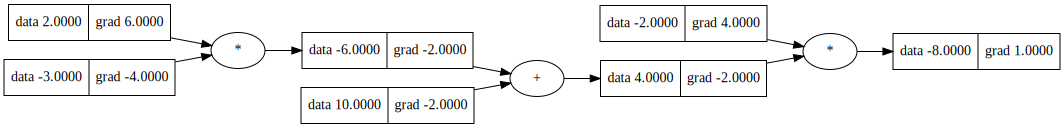

In [77]:
draw_dot(L)

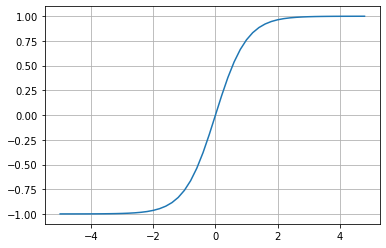

In [78]:
# Activation function - Tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Biological Neuron<br>
<img src="https://cs231n.github.io/assets/nn1/neuron.png" width="600"><br>
Mathematical Model<br>
<img src = "https://cs231n.github.io/assets/nn1/neuron_model.jpeg" width="600">

In [79]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'

# o = n.tanh(); o.label='o'
e = (2*n).exp()
o = (e-1) / (e+1)

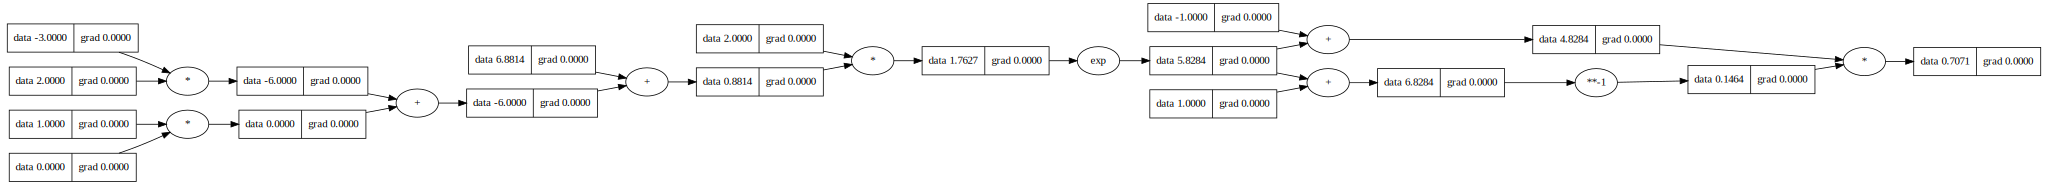

In [80]:
draw_dot(o)

In [81]:
# #Manual Backpropogation through neuron
# o.grad = 1.0

# # o = tanh(n)
# # do/dn = 1 - o**2
# n.grad = 1 - o.data**2

# # Plus operation - local distributer of derivative
# x1w1x2w2.grad = n.grad
# b.grad = n.grad

# x1w1.grad = x1w1x2w2.grad
# x2w2.grad = x1w1x2w2.grad

# # Mult derviative - y of x & z
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

In [82]:
# o.grad = 1.0
# o._backward()

# n._backward()
# x1w1x2w2._backward()

# x1w1._backward()
# x2w2._backward()

In [83]:
# #Topological Sort
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# o.grad = 1.0
# for node in reversed(topo):
#     node._backward()

In [84]:
# #Accumlative gradient

# a = Value(3.0, label='a')
# b = a + a; b.label='b'
# b.backward()
# draw_dot(b)

In [85]:
o.backward()

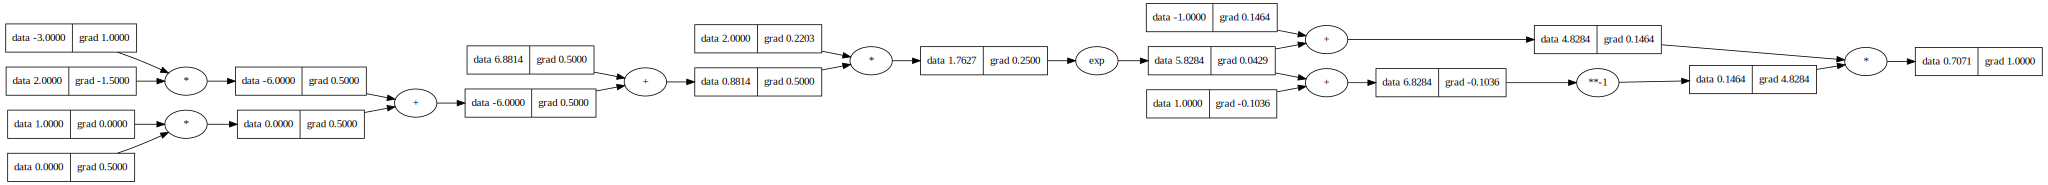

In [86]:
draw_dot(o)

In [87]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [88]:
x = [2.0, 3.0, -1.0]

# # Single neuron
# n = Neuron(2)
# n(x)

# # Layer of neurons
# n = Layer(2, 3)
# n(x)

n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.883710179648296)

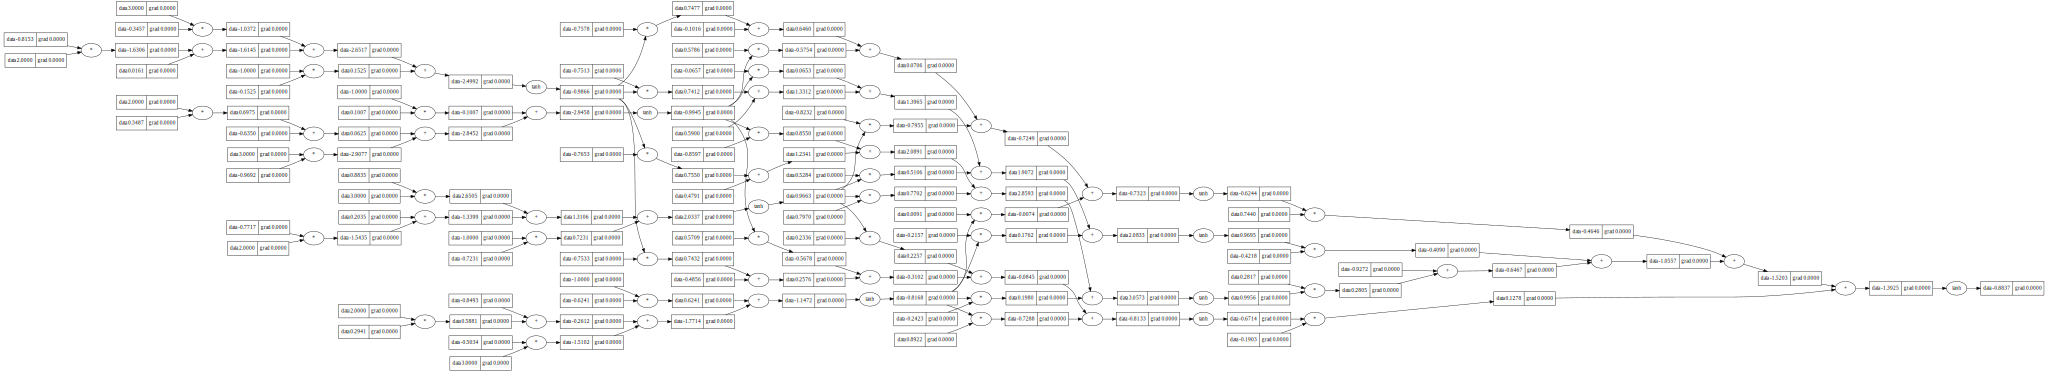

In [89]:
draw_dot(n(x))

In [98]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
    ]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.883710179648296),
 Value(data=-0.595032441857852),
 Value(data=-0.7185961034289905),
 Value(data=-0.8812164262913497)]